In [1]:
import numpy as np
import random
import cv2
import os
import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense
from tensorflow.keras.layers import MaxPooling2D, Activation, Flatten, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical, plot_model

In [2]:
#initial parameters

lr = 1e-2
batch_size = 32 
img_dims = (100,100,3) #specifing image dimensions

data = []
labels = []

# loading image files
image_files = [f for f in glob.glob(r'/content/drive/MyDrive/interview/gender_FaceCounter/gender_dataset' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

# converting images to arrays 
for img in image_files:

    image = cv2.imread(img)
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    #labelling the categories
    label = img.split(os.path.sep)[-2] 
    if label == "woman":
        label = 1
    else:
        label = 0
        
    labels.append([label])

In [3]:
# pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# split dataset for training and validation
x_train,x_test,y_train,y_test = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)

#converting into categorical labels
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


In [4]:

# augmenting the datset 
aug = ImageDataGenerator(rotation_range=20, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True)

In [5]:

#defining input shape

width=img_dims[0]
height=img_dims[1]
depth=img_dims[2]
inputShape = (height, width, depth)

# model creation

model = Sequential()

model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(Conv2D(256, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation("sigmoid"))

In [6]:
epochs=30
from keras.optimizers import Adam

# compile the model
opt = Adam(lr=lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# fit the model
h = model.fit_generator(aug.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test,y_test),
                        steps_per_epoch=len(x_train) // batch_size,
                        epochs=epochs, verbose=1)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
57/57 [==============================] - 110s 2s/step - loss: 1.0671 - accuracy: 0.6711 - val_loss: 9.6147 - val_accuracy: 0.4957
Epoch 2/30
57/57 [==============================] - 108s 2s/step - loss: 0.6733 - accuracy: 0.7516 - val_loss: 0.5930 - val_accuracy: 0.7823
Epoch 3/30
57/57 [==============================] - 108s 2s/step - loss: 0.6446 - accuracy: 0.7582 - val_loss: 1.1295 - val_accuracy: 0.6336
Epoch 4/30
57/57 [==============================] - 108s 2s/step - loss: 0.5714 - accuracy: 0.7901 - val_loss: 0.5055 - val_accuracy: 0.7845
Epoch 5/30
57/57 [==============================] - 108s 2s/step - loss: 0.4976 - accuracy: 0.8247 - val_loss: 0.7972 - val_accuracy: 0.7457
Epoch 6/30
57/57 [==============================] - 107s 2s/step - loss: 0.5036 - accuracy: 0.8044 - val_loss: 0.3237 - val_accuracy: 0.8728
Epoch 7/30
57/57 [==============================] - 108s 2s/step - loss: 0.4600 - accuracy: 0.8247 - val_loss: 0.2579 - val_accuracy: 0.8966
Epoch 8/30
57

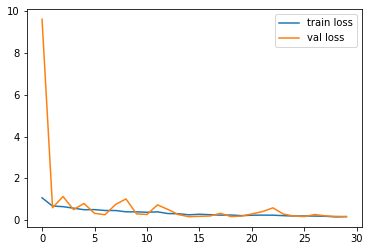

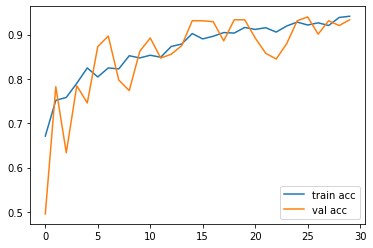

<Figure size 432x288 with 0 Axes>

In [7]:
# loss
import matplotlib.pyplot as plt

plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('loss')

# accuracies
plt.plot(h.history['accuracy'], label='train acc')
plt.plot(h.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('Accuracy')


In [8]:
model.save("/content/drive/MyDrive/interview/gender_FaceCounter/gn_predictor.h5")

In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 6.4MB/s 


predicted label is = women
predicted label is = men
predicted label is = men
predicted label is = women
predicted label is = men
predicted label is = women
predicted label is = men
predicted label is = men


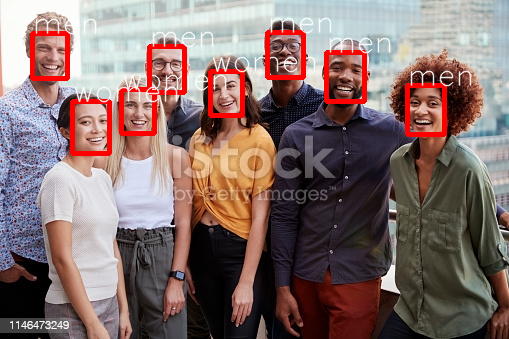

In [ ]:
#testing the model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
from mtcnn.mtcnn import MTCNN

#creating object
detector=MTCNN()

#load model
model = load_model("/content/drive/MyDrive/interview/gender_FaceCounter/gender_predictor.h5")

#definig classes
classes = ['men','women']

#pass input image
image = cv2.imread("/content/drive/MyDrive/interview/gender_FaceCounter/test/test_img6.jpg")

faces=detector.detect_faces(image)

#maintaining seperate counters
males=0
females=0

font = cv2.FONT_HERSHEY_SIMPLEX

# iterating over faces 
for face in range(len(faces)):
    boundingbox=faces[face]['box']
    x=boundingbox[0]
    y=boundingbox[1]
    w=boundingbox[2]
    h=boundingbox[3]

    cv2.rectangle(image, (x,y), (x+w,y+h), (0,0,255),3)
    cropped_image = np.copy(image[y:y+h,x:x+w])

    #preprocess the image according to our model
    res_face = cv2.resize(cropped_image, (96,96))

    res_face = res_face.astype("float") / 255.0
    res_face = img_to_array(res_face)
    res_face = np.expand_dims(res_face, axis=0)
    
    #model prediction
    result = model.predict(res_face)[0] 

    # get label with max accuracy
    idx = np.argmax(result)
    label = classes[idx]
    print("predicted label is =",label)

    #calculating count
    if label=="women":
        females=females+1
    else:
        males=males+1

cv2.rectangle(image,(0,0),(300,30),(255,255,255),-1)
cv2.putText(image," females = {},males = {} ".format(females,males),(0,15),cv2.FONT_HERSHEY_TRIPLEX,0.6,(255, 101, 125),1)
cv2.putText(image," faces detected = " + str(len(faces)),(10,30),cv2.FONT_HERSHEY_TRIPLEX,0.5,(0,0,0),1)
    
                                             
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()